In [ ]:
!pip install pathos
!pip install pandas --upgrade
!pip install tensorflowjs
!pip install shap

# 參考文獻

*   [氣象資料開放平台](https://opendata.cwb.gov.tw/index)
*   [農情調查](https://data.coa.gov.tw/Query/ServiceDetail.aspx?id=038)
*   [農情預測](https://data.coa.gov.tw/Query/ServiceTransDetail.aspx?id=4P84xEv6hd22)
*   CWB-CA3A0F5C-455E-436A-9FB7-530DA1A044E7

# Note

統計中咖啡期作每年都只有一期全年；5-6年生；每年收成月份 不定
產量資料最早在97年；氣候天氣資料應該要從92開始

In [ ]:
from lxml import etree
from scipy.spatial import distance
import matplotlib.pyplot as plt
import requests
import numpy as np
import pandas as pd
import urllib,dask,lxml,re,os,time,io,copy
from IPython.display import display, HTML
from pathos.helpers import cpu_count
from dask.diagnostics import ProgressBar
from functools import reduce
from scipy.stats import zscore



defaultscheduler = "threads" if True else "processes"
defaultnum_workers = 10
std_replace_patterns = [('台北','臺北'),('台中','臺中'),('台南','臺南'),('台東','臺東'),('巿','市'),('霧台鄉','霧臺鄉')]
def city_replace_in_df(srcdf, columns):
  if columns=='': columns = srcdf.columns
  for findstrcombination in std_replace_patterns:
    for str_replace_column in columns:
      srcdf[str_replace_column] = srcdf[str_replace_column].str.replace(findstrcombination[0],findstrcombination[1])
  return srcdf
yield_to_weather_match_years = 5
def filter_join(left,right,on=None):
  leftcols = left.columns
  merged_df = left.merge(right, how='inner', on=on, suffixes=(None, '_y'), ).loc[:, [col for col in leftcols] ]
  return merged_df

# 蒐集資料及預處理資料

## 產量資料

In [ ]:
def get_yield_data_df():
  yield_data_raw = [dask.delayed(requests.get)("https://data.coa.gov.tw/Service/OpenData/FromM/TownCropData.aspx?cropCode=337&year="+str(n)) for n in range(97,110)]
  yield_data_raw = dask.compute(*yield_data_raw, num_workers=defaultnum_workers, scheduler=defaultscheduler)
  for i,x in enumerate(yield_data_raw): yield_data_raw[i].encoding = 'UTF-8'
  yield_data_json = [yd.json() for yd in yield_data_raw]
  yield_data_df = list() #
  for sublist in yield_data_json: yield_data_df.extend(sublist)
  yield_data_df = pd.DataFrame.from_dict(yield_data_df)
  yield_data_df = city_replace_in_df(yield_data_df, columns=['縣市','鄉鎮'])
  yield_data_df = yield_data_df.rename(columns={'縣市':'city','鄉鎮':'district'})
  yield_data_df['citydistrict'] = yield_data_df.apply(lambda x:x['city']+x['district'], axis=1)
  yield_data_df['年度'] = yield_data_df['年度'].astype(int)
  yield_data_df['yield_year'] = yield_data_df['年度']+1911
  yield_data_df = yield_data_df.drop_duplicates()
  yield_data_df = yield_data_df.reset_index(drop=True)
  return yield_data_df

In [ ]:
coffee_yield_df = get_yield_data_df()
yield_zscore_related_cols = ['收穫面積(公頃)','種植面積(公頃)','每公頃收穫量(公斤)','收量(公斤)']
coffee_yield_df[yield_zscore_related_cols] = coffee_yield_df[yield_zscore_related_cols].apply(zscore)
coffee_yield_yr_min = coffee_yield_df.yield_year.min()
coffee_yield_yr_max = coffee_yield_df.yield_year.max()

### 產量部分設定時間序列

In [ ]:
previous_yields = copy.deepcopy(coffee_yield_df)
yield_related_cols = ['收穫面積(公頃)','種植面積(公頃)','每公頃收穫量(公斤)','收量(公斤)']
time_series_yields = {}
for valuecol in yield_related_cols:
  time_series_yield = previous_yields.pivot(index=['citydistrict'], columns='yield_year', values=valuecol)
  time_series_yield.columns = ["{}".format(col).strip() for col in time_series_yield.columns.to_flat_index()]
  time_series_yield = time_series_yield.reset_index()
  time_series_yields[valuecol] = time_series_yield
  display(time_series_yield, "{} done".format(valuecol))

citydistrict      2008      2009  ...      2018      2019      2020
0         南投縣中寮鄉 -0.340187 -0.426746  ... -0.400113 -0.360162  0.127901
1         南投縣仁愛鄉  1.470909  1.564127  ...  1.051427  1.051427  1.317765
2         南投縣信義鄉 -0.360162 -0.346845  ...  0.971526  0.971526  0.205805
3         南投縣南投市 -0.423417 -0.423417  ... -0.270273 -0.270273 -0.270273
4         南投縣名間鄉 -0.200360 -0.246969  ... -0.440063 -0.446722 -0.430742
..           ...       ...       ...  ...       ...       ...       ...
181       高雄市田寮區       NaN       NaN  ... -0.393454 -0.393454 -0.426746
182       高雄市甲仙區 -0.331531 -0.331531  ... -0.283590 -0.286919 -0.292912
183       高雄市美濃區       NaN       NaN  ... -0.434737 -0.415427 -0.433405
184       高雄市茂林區 -0.453380 -0.453380  ...  1.068073  0.881637  0.914929
185      高雄市那瑪夏區  0.072636  0.372266  ...  4.200869  0.372266  0.405558

[186 rows x 14 columns]

'收穫面積(公頃) done'

citydistrict      2008      2009  ...      2018      2019      2020
0         南投縣中寮鄉 -0.357043 -0.442694  ... -0.416340  0.103492  0.106128
1         南投縣仁愛鄉  1.435027  1.527266  ...  1.019952  1.019952  1.382319
2         南投縣信義鄉 -0.376809 -0.363632  ...  0.940890  1.158310  0.183213
3         南投縣南投市 -0.439400 -0.439400  ... -0.287864 -0.287864 -0.287864
4         南投縣名間鄉 -0.218685 -0.264804  ... -0.455871 -0.462459 -0.446647
..           ...       ...       ...  ...       ...       ...       ...
181       高雄市田寮區       NaN       NaN  ... -0.409751 -0.409751 -0.442694
182       高雄市甲仙區 -0.264804 -0.283252  ... -0.301041 -0.304335 -0.310265
183       高雄市美濃區       NaN       NaN  ... -0.450600 -0.431493 -0.449282
184       高雄市茂林區 -0.126446 -0.100092  ...  1.036423  0.851945  0.884888
185      高雄市那瑪夏區  0.545580  0.347925  ...  4.136310  0.347925  0.380868

[186 rows x 14 columns]

'種植面積(公頃) done'

citydistrict      2008      2009  ...      2018      2019      2020
0         南投縣中寮鄉  0.843268  0.843268  ... -0.077771 -0.604080 -0.472503
1         南投縣仁愛鄉  1.211684  1.264315  ...  0.185383  1.501154  1.238000
2         南投縣信義鄉  0.185383  0.185383  ... -0.288295 -0.209348 -0.077771
3         南投縣南投市  0.711691  0.711691  ...  0.593272  0.659060  0.580114
4         南投縣名間鄉  1.395892  1.501154  ... -0.893549 -0.893549 -0.890918
..           ...       ...       ...  ...       ...       ...       ...
181       高雄市田寮區       NaN       NaN  ...  0.711691  0.764322  0.790638
182       高雄市甲仙區  0.869584  0.580114  ...  0.711691  0.711691  0.711691
183       高雄市美濃區       NaN       NaN  ...  0.448537  0.448537  0.448537
184       高雄市茂林區  0.843268  0.448537  ...  0.501168  0.501168  0.448537
185      高雄市那瑪夏區  0.974845  0.711691  ...  0.419590  0.664324  0.369591

[186 rows x 14 columns]

'每公頃收穫量(公斤) done'

citydistrict      2008      2009  ...      2018      2019      2020
0         南投縣中寮鄉 -0.301642 -0.394738  ... -0.387577 -0.379393 -0.099285
1         南投縣仁愛鄉  1.923123  2.078215  ...  0.808012  1.582110  1.754663
2         南投縣信義鄉 -0.348702 -0.337789  ...  0.478594  0.522585  0.046873
3         南投縣南投市 -0.393033 -0.393033  ... -0.244897 -0.240055 -0.245852
4         南投縣名間鄉 -0.095398 -0.146822  ... -0.422565 -0.425225 -0.418814
..           ...       ...       ...  ...       ...       ...       ...
181       高雄市田寮區       NaN       NaN  ... -0.362342 -0.360978 -0.395420
182       高雄市甲仙區 -0.291002 -0.305461  ... -0.249808 -0.253218 -0.259356
183       高雄市美濃區       NaN       NaN  ... -0.407219 -0.389418 -0.405992
184       高雄市茂林區 -0.423383 -0.424406  ...  1.009482  0.833793  0.836998
185      高雄市那瑪夏區  0.169637  0.421986  ...  3.813695  0.406641  0.340825

[186 rows x 14 columns]

'收量(公斤) done'

### 將產量時間序列資料合併回去原始資料

In [ ]:
coffee_yield_df_with_time_series_data = {}
for yield_related_col in yield_related_cols: coffee_yield_df_with_time_series_data[yield_related_col] = []

for compare_yield_yr in range(coffee_yield_yr_min+yield_to_weather_match_years, coffee_yield_yr_max+1):
  merge_in_time_period = range(compare_yield_yr-yield_to_weather_match_years, compare_yield_yr)
  for yield_related_col in yield_related_cols:
    tp_target_colnames = ['citydistrict']+list(map(str, merge_in_time_period))
    new_target_colnames = ['citydistrict']+["{}{}".format(yield_related_col,i) for i,col in enumerate(merge_in_time_period)]
    colnames_conversion_dict = dict(zip(tp_target_colnames, new_target_colnames))
    tp_target_df = time_series_yields[yield_related_col].loc[:,tp_target_colnames].rename(columns=colnames_conversion_dict)
    tp_target_df = tp_target_df.assign(**{'yield_year':compare_yield_yr})
    coffee_yield_df_with_time_series_data[yield_related_col].append(tp_target_df)

for yield_related_col in yield_related_cols:
  coffee_yield_df_with_time_series_data[yield_related_col] = pd.concat(coffee_yield_df_with_time_series_data[yield_related_col])
  coffee_yield_df_with_time_series_data[yield_related_col] = coffee_yield_df_with_time_series_data[yield_related_col].dropna(axis = 0, how = 'any', inplace = False)

coffee_yield_df_with_time_series_data = reduce(lambda x,y: x.merge(y, how='inner'), coffee_yield_df_with_time_series_data.values())
coffee_yield_df_with_time_series_data = coffee_yield_df.merge(coffee_yield_df_with_time_series_data, how='inner')
coffee_yield_df_with_time_series_data.to_csv("coffee_yield_df.csv")
display(coffee_yield_df_with_time_series_data)

年度  期作 city district  ...   收量(公斤)1   收量(公斤)2   收量(公斤)3   收量(公斤)4
0    102  全年  臺北市      文山區  ... -0.429453 -0.428908 -0.428908 -0.428976
1    102  全年  新北市      石碇區  ... -0.423724 -0.423724 -0.423724 -0.423929
2    102  全年  新北市      石門區  ... -0.414176 -0.408038 -0.408038 -0.410084
3    102  全年  新北市      三峽區  ... -0.425088 -0.419632 -0.401899 -0.387577
4    102  全年  新竹縣      關西鎮  ... -0.430544 -0.392010 -0.199202 -0.133727
..   ...  ..  ...      ...  ...       ...       ...       ...       ...
811  109  全年  花蓮縣      光復鄉  ... -0.326195 -0.282545 -0.268086 -0.224232
812  109  全年  花蓮縣      瑞穗鄉  ...  0.841773  0.833656  0.735309  0.748676
813  109  全年  花蓮縣      玉里鎮  ... -0.314532 -0.314532 -0.399512 -0.375369
814  109  全年  花蓮縣      壽豐鄉  ... -0.253082 -0.265495 -0.307507 -0.318692
815  109  全年  嘉義市       東區  ... -0.416904 -0.414722 -0.363501 -0.363501

[816 rows x 32 columns]

### 農產年對天氣年配對

In [ ]:
yield_to_weather_match_years_df = []
for yield_year in range(coffee_yield_df.yield_year.min(), coffee_yield_df.yield_year.max()+1):
  tp_yield_df = pd.DataFrame({'weather_year': range(yield_year-yield_to_weather_match_years+1,yield_year+1) }).assign(**{'yield_year':yield_year})
  yield_to_weather_match_years_df.append(tp_yield_df)
yield_to_weather_match_years_df = pd.concat(yield_to_weather_match_years_df)
display(yield_to_weather_match_years_df)
yield_to_weather_match_years_df.to_csv('yield_to_weather_match_years_df.csv')

weather_year  yield_year
0           2004        2008
1           2005        2008
2           2006        2008
3           2007        2008
4           2008        2008
..           ...         ...
0           2016        2020
1           2017        2020
2           2018        2020
3           2019        2020
4           2020        2020

[65 rows x 2 columns]

### 各鄉鎮市區地理中心資訊

In [ ]:
def get_district_center_df():
  dcdf = requests.get("http://quality.data.gov.tw/dq_download_csv.php?nid=25489&md5_url=a85eb04185242dd82bf3db71756eb6da")
  dcdf.encoding = 'UTF-8'
  dcdf = dcdf.text
  dcdf = io.StringIO(dcdf) #.replace("巿","市")
  dcdf = pd.read_csv(dcdf,encoding='UTF-8')
  dcdf = city_replace_in_df(dcdf, ['行政區名'])
  dcdf = dcdf.rename(columns={'行政區名':'citydistrict','_x0033_碼郵遞區號':'zipcode'})
  dcdf['city'] = dcdf['citydistrict'].str.extract("(.{2}[縣|市]{1}){1}?")
  dcdf['district'] = dcdf['citydistrict'].str.extract(".{2}[縣|市]{1}([\u4E00-\u9FFF]{1,5}?[鄉鎮市區]{1,2}){1}?")
  return dcdf

district_center_df = get_district_center_df()
display(district_center_df[district_center_df['city']=='臺南市'])
district_center_df.to_csv("district_center_df.csv")

citydistrict  zipcode  ...  city  district
220       臺南市中西區      700  ...   臺南市       中西區
221        臺南市東區      701  ...   臺南市        東區
222        臺南市南區      702  ...   臺南市        南區
223        臺南市北區      704  ...   臺南市        北區
224       臺南市安平區      708  ...   臺南市       安平區
225       臺南市安南區      709  ...   臺南市       安南區
226       臺南市永康區      710  ...   臺南市       永康區
227       臺南市歸仁區      711  ...   臺南市       歸仁區
228       臺南市新化區      712  ...   臺南市       新化區
229       臺南市左鎮區      713  ...   臺南市       左鎮區
230       臺南市玉井區      714  ...   臺南市       玉井區
231       臺南市楠西區      715  ...   臺南市       楠西區
232       臺南市南化區      716  ...   臺南市       南化區
233       臺南市仁德區      717  ...   臺南市       仁德區
234       臺南市關廟區      718  ...   臺南市       關廟區
235       臺南市龍崎區      719  ...   臺南市       龍崎區
236       臺南市官田區      720  ...   臺南市       官田區
237       臺南市麻豆區      721  ...   臺南市       麻豆區
238       臺南市佳里區      722  ...   臺南市       佳里區
239       臺南市西港區      723  ...   臺南市       西港區
240       臺南市七股區      724  ...   臺南市       七股區
241       臺南市將軍區      725  ...   臺南市       將軍區
242       臺南市學甲區      726  ...   臺南市       學甲區
243       臺南市北門區      727  ...   臺南市       北門區
244       臺南市新營區      730  ...   臺南市       新營區
245       臺南市後壁區      731  ...   臺南市       後壁區
246       臺南市白河區      732  ...   臺南市       白河區
247       臺南市東山區      733  ...   臺南市       東山區
248       臺南市六甲區      734  ...   臺南市       六甲區
249       臺南市下營區      735  ...   臺南市       下營區
250       臺南市柳營區      736  ...   臺南市       柳營區
251       臺南市鹽水區      737  ...   臺南市       鹽水區
252       臺南市善化區      741  ...   臺南市       善化區
253       臺南市大內區      742  ...   臺南市       大內區
254       臺南市山上區      743  ...   臺南市       山上區
255       臺南市新市區      744  ...   臺南市       新市區
256       臺南市安定區      745  ...   臺南市       安定區

[37 rows x 7 columns]

### 各氣象站基本資料

In [ ]:
def get_weather_station_attrs_df():
  weather_station_attrs = requests.get("https://e-service.cwb.gov.tw/wdps/obs/state.htm")
  weather_station_attrs.encoding = 'UTF-8'
  weather_station_attrs = weather_station_attrs.text.replace(
      re.match(pattern="(<meta{1}[\w\d\s\W\D\S]+</style>{1})", string=weather_station_attrs.text)[0],""
  )
  weather_station_etree = etree.HTML(weather_station_attrs)
  r = weather_station_etree.xpath("//div[@id='existing_station']/table")[0]
  weather_station_existing_df = pd.read_html(etree.tostring(r))[0]
  weather_station_existing_df['status'] = "現存"
  r = weather_station_etree.xpath("//div[@id='revoked_station']/table")[0]
  weather_station_revoked_df = pd.read_html(etree.tostring(r))[0]
  weather_station_revoked_df['status'] = '已撤站'
  weather_station_attr_df = pd.concat([weather_station_existing_df,weather_station_revoked_df]).reset_index(drop=True).rename(columns={'站號':'stationid','站名':'stationname','城市':'city'})
  weather_station_attr_df['district'] = weather_station_attr_df['地址'].str.extract(r"([\u4E00-\u9FFF]{1,5}?[鄉鎮市區]{1,2}){1}?")
  weather_station_attr_df = city_replace_in_df(weather_station_attr_df, ['city','district'])
  weather_station_attr_df['begin_year'] = weather_station_attr_df['資料起始日期'].str.extract("(\d+)\/{1}").astype(int)
  weather_station_attr_df = weather_station_attr_df.rename(columns={'海拔高度(m)':'stationaltitude'})
  return weather_station_attr_df

weather_station_attr_df_preferred = get_weather_station_attrs_df()
weather_station_attr_df_preferred = weather_station_attr_df_preferred[weather_station_attr_df_preferred['status']=='現存']
weather_station_attr_df_preferred = weather_station_attr_df_preferred[weather_station_attr_df_preferred['begin_year']<=2003].sort_values(by=['city','district'],ascending=False)
display(weather_station_attr_df_preferred)
weather_station_attr_df_preferred.to_csv("weather_station_attr_df_preferred.csv")

stationid stationname  stationaltitude  ...  status  district begin_year
591    C1V160        達卡努瓦           1040.0  ...      現存      那瑪夏區       1992
383    C0V310          美濃             46.0  ...      現存       美濃區       1992
381    C0V250          甲仙            298.0  ...      現存       甲仙區       1992
386    C0V370         古亭坑             74.0  ...      現存       田寮區       1992
599    C1V390          尖山             60.0  ...      現存       燕巢區       1992
..        ...         ...              ...  ...     ...       ...        ...
509    C1H900          清流            934.0  ...      現存       仁愛鄉       1991
514    C1I020          萬大           1120.0  ...      現存       仁愛鄉       1992
515    C1I030          武界            948.0  ...      現存       仁愛鄉       1992
533    C1I320         奧萬大           1275.0  ...      現存       仁愛鄉       2002
534    C1I330         楓樹林           1266.0  ...      現存       仁愛鄉       2002

[167 rows x 15 columns]

### 產量資料與天氣測站資料串連

In [ ]:
copied_weather_station_attr_df_preferred = copy.deepcopy(weather_station_attr_df_preferred)
copied_weather_station_attr_df_preferred = copied_weather_station_attr_df_preferred.rename(columns={'city':'weatherstationcity','district':'weatherstationdistrict'})
yield_weather_station_pairs = coffee_yield_df_with_time_series_data.merge(district_center_df, how='left', on=['city','district','citydistrict']) #coffee_yield_df
yield_weather_station_pairs = yield_weather_station_pairs[~pd.isnull(yield_weather_station_pairs['中心點經度'])]
yield_weather_station_pairs = yield_weather_station_pairs.merge(copied_weather_station_attr_df_preferred, how='cross')

In [ ]:
yield_weather_station_pairs['district_axis'] = yield_weather_station_pairs.loc[:,['中心點經度','中心點緯度']].values.tolist()
yield_weather_station_pairs['weather_station_axis'] = yield_weather_station_pairs.loc[:,['經度','緯度']].values.tolist()

yield_weather_station_pairs['distance_from_district_to_weather_station'] = yield_weather_station_pairs.apply(
    lambda x: distance.euclidean(x['district_axis'], x['weather_station_axis']), axis=1 )

yield_weather_station_pairs = yield_weather_station_pairs.sort_values(by=['citydistrict','yield_year','distance_from_district_to_weather_station'], ascending=True) #.loc[:,['縣市鄉鎮名稱','yield_year','weather_station_df_stationname','distance_from_district_to_weather_station']]
yield_weather_station_pairs = yield_weather_station_pairs.loc[yield_weather_station_pairs.groupby(['citydistrict','yield_year']).distance_from_district_to_weather_station.idxmin()]
yield_weather_station_pairs = yield_weather_station_pairs.sort_values(by=['stationid','yield_year']).rename(
    columns={'收穫面積(公頃)':'yield_area','種植面積(公頃)':'planting_area','每公頃收穫量(公斤)':'yield_amount_per_area','收量(公斤)':'yield_amount'}
).reset_index(drop=True)
yield_weather_station_pairs.to_csv('yield_weather_station_pairs.csv')
display(yield_weather_station_pairs.shape)
display(yield_weather_station_pairs[yield_weather_station_pairs['stationname']=='板橋'])
yield_weather_station_pairs_simple = yield_weather_station_pairs.loc[:,['city','district','yield_year','stationid','stationname']].drop_duplicates()
display(yield_weather_station_pairs_simple)

(816, 54)

年度  期作  ...     weather_station_axis distance_from_district_to_weather_station
0  107  全年  ...  [121.442017, 24.997647]                                  0.033603
1  108  全年  ...  [121.442017, 24.997647]                                  0.033603
2  109  全年  ...  [121.442017, 24.997647]                                  0.033603

[3 rows x 54 columns]

city district  yield_year stationid stationname
0    新北市      土城區        2018    466880          板橋
1    新北市      土城區        2019    466880          板橋
2    新北市      土城區        2020    466880          板橋
3    新北市      八里區        2017    466900          淡水
4    新北市      淡水區        2017    466900          淡水
..   ...      ...         ...       ...         ...
811  臺南市      白河區        2018    C1X040          東原
812  臺南市      東山區        2019    C1X040          東原
813  臺南市      白河區        2019    C1X040          東原
814  臺南市      東山區        2020    C1X040          東原
815  臺南市      白河區        2020    C1X040          東原

[816 rows x 5 columns]

In [ ]:
get_monthly_data = False
compare_key_for_fetch_weather_data = ['stationid','stationname','yield_year']
fetch_weather_data_src_stations_df = yield_weather_station_pairs.drop_duplicates(compare_key_for_fetch_weather_data)
fetch_weather_data_src_stations_df = fetch_weather_data_src_stations_df.loc[:,compare_key_for_fetch_weather_data]
fetch_weather_data_src_stations_df_minyrs = fetch_weather_data_src_stations_df.groupby(['stationid','stationname'])['yield_year'].min()
fetch_weather_data_src_stations_df_maxyrs = fetch_weather_data_src_stations_df.groupby(['stationid','stationname'])['yield_year'].max()
fetch_weather_data_src_stations_dfs = []
for index in fetch_weather_data_src_stations_df_minyrs.index:
  min_year_of_fetch_data = fetch_weather_data_src_stations_df_minyrs[index]-yield_to_weather_match_years #有產出的年份往前推5年抓天氣資料
  max_year_of_fetch_data = fetch_weather_data_src_stations_df_maxyrs[index]
  single_fetch_weather_data_src_stations_df = pd.DataFrame.from_dict({'year': range(min_year_of_fetch_data, max_year_of_fetch_data+1)}, orient='columns')
  single_fetch_weather_data_src_stations_df = single_fetch_weather_data_src_stations_df.assign(**{'stationid':index[0], 'stationname':index[1]})
  fetch_weather_data_src_stations_dfs.append(single_fetch_weather_data_src_stations_df)
fetch_weather_data_src_stations_df = pd.concat(fetch_weather_data_src_stations_dfs).reset_index(drop=True)
if get_monthly_data:
  temp_month_df = pd.DataFrame(data={'month': [str(m).zfill(2) for m in range(1,13)] })
  fetch_weather_data_src_stations_df = fetch_weather_data_src_stations_df.merge(temp_month_df, how='cross')
  fetch_weather_data_src_stations_df['datepicker'] = fetch_weather_data_src_stations_df.apply(lambda x: "{}-{}".format(x['year'], x['month']), axis=1)
else:
  fetch_weather_data_src_stations_df['datepicker'] = fetch_weather_data_src_stations_df['year']

fetch_weather_data_src_stations_df['weather_year'] = fetch_weather_data_src_stations_df['year']
display(fetch_weather_data_src_stations_df[fetch_weather_data_src_stations_df.stationname=='板橋'])

year stationid stationname  datepicker  weather_year
0  2013    466880          板橋        2013          2013
1  2014    466880          板橋        2014          2014
2  2015    466880          板橋        2015          2015
3  2016    466880          板橋        2016          2016
4  2017    466880          板橋        2017          2017
5  2018    466880          板橋        2018          2018
6  2019    466880          板橋        2019          2019
7  2020    466880          板橋        2020          2020

### 各氣象站觀測資料

In [ ]:
def get_station_monthly_data_retrieve(stationinfo):
  station_info_message = list(map(str,stationinfo.values()))
  try:
    stationinfo['urlencoded_name'] = urllib.parse.quote(stationinfo['stationname'], safe='~@#$&()*!+=:;,.?/\'', encoding='UTF-8').replace("%","%25")
    fetch_url_scriptname = 'MonthDataController' if get_monthly_data==True else 'YearDataController'
    weather_data_raw = "https://e-service.cwb.gov.tw/HistoryDataQuery/{}.do?command=viewMain&station={}&datepicker={}&stname={}".format(
        fetch_url_scriptname, stationinfo['stationid'], stationinfo['datepicker'], stationinfo['urlencoded_name']
        )
    weather_data_raw = requests.get(weather_data_raw)
    weather_data_raw.encoding = 'UTF-8'
    return [weather_data_raw.text,stationinfo]
  except Exception as e:
    print("retrieving error at "+" ".join(station_info_message)+" for "+str(e))
    return ["retrieving error",stationinfo]

def get_station_monthly_data_parse(stationinfo):
  retrieved_text = stationinfo[0]
  stationinfo = stationinfo[1]
  station_info_message = map(str,list(stationinfo.values()))
  try:
    weather_data_etree = etree.HTML(retrieved_text)
    #觀測時間(day)	測站氣壓(hPa)	海平面氣壓(hPa)	測站最高氣壓(hPa)	測站最高氣壓時間(LST)	測站最低氣壓(hPa)	測站最低氣壓時間(LST)	氣溫(℃)	最高氣溫(℃)	最高氣溫時間(LST)	最低氣溫(℃)	最低氣溫時間(LST)	露點溫度(℃)	相對溼度(%)	最小相對溼度(%)	最小相對溼度時間(LST)	風速(m/s)	風向(360degree)	最大陣風(m/s)	最大陣風風向(360degree)	最大陣風風速時間(LST)	降水量(mm)	降水時數(hour)	最大十分鐘降水量(mm)	最大十分鐘降水量起始時間(LST)	最大六十分鐘降水量(mm)	最大六十分鐘降水量起始時間(LST)	日照時數(hour)	日照率(%)	全天空日射量(MJ/㎡)	能見度(km)	A型蒸發量(mm)	日最高紫外線指數	日最高紫外線指數時間(LST)	總雲量(0~10)
    r = weather_data_etree.xpath("//table[@id='MyTable']//tr[position()>2]")
    weather_data_df = [etree.tostring(tr, encoding='unicode') for tr in r]
    weather_data_df = "<table>"+"".join(weather_data_df)+"</table>"
    weather_data_df = pd.read_html(weather_data_df)[0]
    weather_data_df = weather_data_df.assign(**stationinfo).drop(columns=['urlencoded_name'])
    #for key,value in stationinfo.items(): weather_data_df = weather_data_df.assign(key=value)
  except Exception as e:
    parsing_err_text = "parsing error at "+" ".join(station_info_message)+" for "+str(e)
    weather_data_df = parsing_err_text
    print(parsing_err_text)
  weather_data_df = "retrieving error at "+" ".join(station_info_message) if retrieved_text=="retrieving error" else weather_data_df
  return weather_data_df

## 抓氣象觀測資料
花時間很長

In [ ]:
get_weather_station_jobs = []
for record in fetch_weather_data_src_stations_df.to_records(index=False):
  stationinfo = dict(zip(fetch_weather_data_src_stations_df.columns,record))
  get_weather_station_jobs.append(dask.delayed(get_station_monthly_data_retrieve)(stationinfo) )
  #break
with dask.config.set(num_workers=15, scheduler=defaultscheduler):  #30
    with ProgressBar(): #start at 14:38
      weather_station_observation_data_raw = dask.compute(*get_weather_station_jobs) #defaultnum_workers
weather_station_observation_data_raw = [dask.delayed(get_station_monthly_data_parse)(d) for d in weather_station_observation_data_raw]
with dask.config.set(num_workers=600, scheduler=defaultscheduler):  #204
    with ProgressBar():
      weather_station_observation_data_raw = dask.compute(*weather_station_observation_data_raw) #defaultnum_workers
copied_weather_station_observation_data_raw = copy.deepcopy(weather_station_observation_data_raw)
weather_station_observation_data_raw = copy.deepcopy(copied_weather_station_observation_data_raw)

[########################################] | 100% Completed | 50.0s
[########################################] | 100% Completed | 55.2s


In [ ]:
weather_station_observation_data_raw = pd.concat(copied_weather_station_observation_data_raw).drop(columns=['year']) #.rename(columns={'year':'weather_year'})
weather_station_observation_data_raw['month'] = weather_station_observation_data_raw['ObsTime']
weather_station_observation_data_raw = weather_station_observation_data_raw.sort_values(by=['stationid','weather_year','month'])
weather_station_observation_data_raw = weather_station_observation_data_raw.reset_index(drop=True)
weather_station_observation_data_raw = weather_station_observation_data_raw.replace(['/','&','X','...','T'], np.nan)
weather_station_observation_data_raw.to_csv('weather_station_observation_data_raw.csv')
weather_station_observation_data_raw[(weather_station_observation_data_raw.stationname=='板橋') & (weather_station_observation_data_raw.weather_year==2020)]

ObsTime StnPres  SeaPres  ... datepicker weather_year month
84        1  1018.9   1020.2  ...       2020         2020     1
85        2  1020.8   1022.1  ...       2020         2020     2
86        3  1015.0   1016.2  ...       2020         2020     3
87        4  1015.4   1016.7  ...       2020         2020     4
88        5  1007.7   1008.9  ...       2020         2020     5
89        6  1006.5   1007.7  ...       2020         2020     6
90        7  1006.4   1007.6  ...       2020         2020     7
91        8  1005.6   1006.8  ...       2020         2020     8
92        9  1008.7   1009.9  ...       2020         2020     9
93       10  1013.5   1014.7  ...       2020         2020    10
94       11  1017.3   1018.5  ...       2020         2020    11
95       12  1019.1   1020.4  ...       2020         2020    12

[12 rows x 40 columns]

In [ ]:
yield_to_weather_match_years_df

weather_year  yield_year
0           2004        2008
1           2005        2008
2           2006        2008
3           2007        2008
4           2008        2008
..           ...         ...
0           2016        2020
1           2017        2020
2           2018        2020
3           2019        2020
4           2020        2020

[65 rows x 2 columns]

In [ ]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 10000
weather_station_observation_data_raw_grouped = copy.deepcopy(weather_station_observation_data_raw)
weather_station_observation_data_raw_grouped['month'] = weather_station_observation_data_raw_grouped['ObsTime']
weather_station_observation_data_raw_grouped = yield_to_weather_match_years_df.merge(weather_station_observation_data_raw_grouped, how='left').sort_values(by=['stationid','yield_year','weather_year','month']).reset_index(drop=True)

weather_station_observation_data_raw_grouped['ObsTime'] = weather_station_observation_data_raw_grouped.groupby(['stationid','yield_year']).cumcount()
weather_station_observation_data_raw_grouped['ObsTime_str'] = weather_station_observation_data_raw_grouped['ObsTime'].astype(str)
weather_station_observation_data_raw_grouped['ObsTime_str'] = weather_station_observation_data_raw_grouped['ObsTime_str'].apply(lambda x: str(x).zfill(2) )

weather_station_observation_cols = weather_station_observation_data_raw_grouped.columns.tolist()
cols_myown_first_cols = ['stationid','stationname','yield_year','weather_year','ObsTime','ObsTime_str','datepicker','month']
weather_station_observation_cols = cols_myown_first_cols+[col for col in weather_station_observation_cols if col not in cols_myown_first_cols]
weather_station_observation_data_raw_grouped = weather_station_observation_data_raw_grouped.loc[:,weather_station_observation_cols]
weather_station_observation_data_raw_grouped = weather_station_observation_data_raw_grouped.reset_index(drop=True)#.drop(columns=['stationname'])
weather_station_observation_data_raw_grouped = weather_station_observation_data_raw_grouped.reset_index(drop=True)

#correct
needed_weather_attrs = ['StnPres','StnPresMax','StnPresMin','Temperature','T Max','T Min','WS','WD','WSGust','WDGust','Precp','Precp1DayMax','RH','SunShine']
#,'SeaPres','Td dew point','PrecpHour','PrecpDay','PrecpMax10','PrecpMax60','EvapA','GloblRad','Cloud Amount'
#,'StnPresMaxTime','StnPresMinTime','T Max Time','T Min Time','WGustTime','PrecpMax10Time','PrecpMax60Time','Precp1DayMaxTime','UVI Max Mean','UVI Max','UVI Max Time'
weather_station_observation_data_raw_groupeds = {}
select_weather_station_observation_criteria = []
empty_value_happeneds = {}
for valuecol in needed_weather_attrs:
  weather_station_observation_data_raw_grouped_tp = weather_station_observation_data_raw_grouped.pivot(index=['stationid','stationname','yield_year'], columns=['ObsTime_str'], values=[valuecol])
  weather_station_observation_data_raw_grouped_tp.columns = [''.join(col).strip() for col in weather_station_observation_data_raw_grouped_tp.columns.to_flat_index()]
  weather_station_observation_data_raw_grouped_tp = weather_station_observation_data_raw_grouped_tp.reset_index().reset_index(drop=True)
  for col in set(weather_station_observation_data_raw_grouped_tp.columns)-set(['stationid','stationname','yield_year']): weather_station_observation_data_raw_grouped_tp[col] = weather_station_observation_data_raw_grouped_tp[col].astype('float')
  missingvalues_sum = weather_station_observation_data_raw_grouped_tp.isnull().sum()
  empty_value_happeneds[valuecol] = (missingvalues_sum, missingvalues_sum.sum())
  weather_station_observation_data_raw_grouped_tp = weather_station_observation_data_raw_grouped_tp.dropna(axis = 0, how = 'any', inplace = False)
  weather_station_observation_data_raw_groupeds[valuecol] = weather_station_observation_data_raw_grouped_tp
  select_weather_station_observation_criteria.append(weather_station_observation_data_raw_grouped_tp.loc[:,['stationid','yield_year']])
  display( valuecol, weather_station_observation_data_raw_grouped_tp.shape, "total missing values are {}".format(empty_value_happeneds[valuecol][1]) )
pd.reset_option('all')

'StnPres'

(266, 63)

'total missing values are 33213'

'StnPresMax'

(256, 63)

'total missing values are 34218'

'StnPresMin'

(255, 63)

'total missing values are 34233'

'Temperature'

(280, 63)

'total missing values are 28942'

'T Max'

(256, 63)

'total missing values are 34218'

'T Min'

(256, 63)

'total missing values are 34218'

'WS'

(277, 63)

'total missing values are 29080'

'WD'

(275, 63)

'total missing values are 29082'

'WSGust'

(255, 63)

'total missing values are 34258'

'WDGust'

(255, 63)

'total missing values are 34258'

'Precp'

(399, 63)

'total missing values are 11093'

'Precp1DayMax'

(416, 63)

'total missing values are 11068'

'RH'

(170, 63)

'total missing values are 41410'

'SunShine'

(112, 63)

'total missing values are 45445'

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



### 把資料縮到沒有遺漏值的完整對象

In [ ]:
final_select_weather_station_observation_criteria = reduce(lambda x,y:filter_join(x,y,on=['stationid','yield_year']),[yield_weather_station_pairs_simple]+select_weather_station_observation_criteria)
final_select_weather_station_observation_criteria = final_select_weather_station_observation_criteria.sort_values(by=['stationid','yield_year'])
display(final_select_weather_station_observation_criteria)
final_weather_station_observation_data_raw_groupeds = {}
for key,value in weather_station_observation_data_raw_groupeds.items():
  tpvalue = filter_join(value, final_select_weather_station_observation_criteria, on=['stationid','yield_year']);
  tpvalue = tpvalue.sort_values(by=['stationid','yield_year'])
  numeric_cols = [col for col in tpvalue.select_dtypes(include=[np.number]).columns if col!='yield_year']
  tpvalue[numeric_cols] = tpvalue[numeric_cols].apply(zscore)
  tpvalue = tpvalue.reset_index(drop=True)
  final_weather_station_observation_data_raw_groupeds[key] = tpvalue[numeric_cols]
  display(key, tpvalue, value.shape, tpvalue.shape)
final_yield_weather_station_pairs = filter_join(yield_weather_station_pairs, final_select_weather_station_observation_criteria)
final_yield_weather_station_pairs = final_yield_weather_station_pairs.sort_values(by=['stationid','yield_year']).reset_index(drop=True)
display('yield_weather_station_pairs', yield_weather_station_pairs.shape, final_yield_weather_station_pairs.shape)

city district  yield_year stationid stationname
0   新北市      土城區        2018    466880          板橋
1   新北市      土城區        2019    466880          板橋
2   新北市      土城區        2020    466880          板橋
3   新北市      八里區        2017    466900          淡水
4   新北市      淡水區        2017    466900          淡水
..  ...      ...         ...       ...         ...
78  臺東縣      臺東市        2016    467660          臺東
79  臺東縣      臺東市        2017    467660          臺東
80  臺東縣      臺東市        2018    467660          臺東
81  臺東縣      臺東市        2019    467660          臺東
82  臺東縣      臺東市        2020    467660          臺東

[83 rows x 5 columns]

'StnPres'

stationid stationname  yield_year  ...  StnPres57  StnPres58  StnPres59
0     466880          板橋        2018  ...   0.477066   0.354386   0.364579
1     466880          板橋        2019  ...   0.420113   0.347449   0.385281
2     466880          板橋        2020  ...   0.363160   0.389073   0.330075
3     466900          淡水        2017  ...   0.242135   0.236452   0.350777
4     466900          淡水        2017  ...   0.242135   0.236452   0.350777
..       ...         ...         ...  ...        ...        ...        ...
78    467660          臺東        2016  ...   0.178063   0.319700   0.281769
79    467660          臺東        2017  ...   0.213659   0.229515   0.295571
80    467660          臺東        2018  ...   0.377398   0.333574   0.274868
81    467660          臺東        2019  ...   0.377398   0.243390   0.274868
82    467660          臺東        2020  ...   0.284850   0.326637   0.185158

[83 rows x 63 columns]

(266, 63)

(83, 63)

'StnPresMax'

stationid stationname  yield_year  ...  StnPresMax57  StnPresMax58  StnPresMax59
0     466880          板橋        2018  ...      0.323920      0.283431      0.495602
1     466880          板橋        2019  ...      0.392575      0.411319      0.488969
2     466880          板橋        2020  ...      0.303323      0.377664      0.475704
3     466900          淡水        2017  ...      0.529885      0.357471      0.396114
4     466900          淡水        2017  ...      0.529885      0.357471      0.396114
..       ...         ...         ...  ...           ...           ...           ...
78    467660          臺東        2016  ...      0.330785      0.344009      0.203771
79    467660          臺東        2017  ...      0.330785      0.236314      0.283361
80    467660          臺東        2018  ...      0.268996      0.296893      0.276728
81    467660          臺東        2019  ...      0.200340      0.236314      0.263463
82    467660          臺東        2020  ...      0.166013      0.236314      0.263463

[83 rows x 63 columns]

(256, 63)

(83, 63)

'StnPresMin'

stationid stationname  yield_year  ...  StnPresMin57  StnPresMin58  StnPresMin59
0     466880          板橋        2018  ...      0.649409      0.449154      0.340903
1     466880          板橋        2019  ...      0.019266      0.280531      0.441828
2     466880          板橋        2020  ...      0.527446      0.224323      0.348112
3     466900          淡水        2017  ...      0.290295      0.140012      0.434619
4     466900          淡水        2017  ...      0.290295      0.140012      0.434619
..       ...         ...         ...  ...           ...           ...           ...
78    467660          臺東        2016  ...      0.480016      0.385921      0.348112
79    467660          臺東        2017  ...      0.283520      0.147038      0.420201
80    467660          臺東        2018  ...      0.439362      0.435102      0.175098
81    467660          臺東        2019  ...     -0.116249      0.245401      0.319277
82    467660          臺東        2020  ...      0.480016      0.343765      0.232770

[83 rows x 63 columns]

(255, 63)

(83, 63)

'Temperature'

stationid stationname  ...  Temperature58  Temperature59
0     466880          板橋  ...      -0.259756      -0.055679
1     466880          板橋  ...      -0.783778      -0.351918
2     466880          板橋  ...       0.189406      -0.766652
3     466900          淡水  ...      -0.708918      -1.003643
4     466900          淡水  ...      -0.708918      -1.003643
..       ...         ...  ...            ...            ...
78    467660          臺東  ...       0.938009       1.603259
79    467660          臺東  ...       1.312310       0.714543
80    467660          臺東  ...       0.938009       1.662507
81    467660          臺東  ...       0.713428       1.129277
82    467660          臺東  ...       1.087729       1.129277

[83 rows x 63 columns]

(280, 63)

(83, 63)

'T Max'

stationid stationname  yield_year  ...   T Max57   T Max58   T Max59
0     466880          板橋        2018  ... -1.098515  0.137381  1.268445
1     466880          板橋        2019  ...  0.910215 -0.149478  0.374451
2     466880          板橋        2020  ...  1.155182  1.141388 -0.992834
3     466900          淡水        2017  ...  1.057195  0.424240 -0.677307
4     466900          淡水        2017  ...  1.057195  0.424240 -0.677307
..       ...         ...         ...  ...       ...       ...       ...
78    467660          臺東        2016  ... -0.216633  0.209096  0.689979
79    467660          臺東        2017  ...  0.126320  0.065667 -0.098840
80    467660          臺東        2018  ... -1.000528 -0.794911  1.005506
81    467660          臺東        2019  ... -0.510594 -0.579766  0.058924
82    467660          臺東        2020  ... -0.559587 -0.006048 -0.256604

[83 rows x 63 columns]

(256, 63)

(83, 63)

'T Min'

stationid stationname  yield_year  ...   T Min57   T Min58   T Min59
0     466880          板橋        2018  ... -0.758244  0.362033 -0.103950
1     466880          板橋        2019  ... -0.017260 -0.405986 -0.578480
2     466880          板橋        2020  ... -0.066659  0.746042 -1.958932
3     466900          淡水        2017  ... -0.906440 -0.597990 -0.405924
4     466900          淡水        2017  ... -0.906440 -0.597990 -0.405924
..       ...         ...         ...  ...       ...       ...       ...
78    467660          臺東        2016  ...  1.909298  1.178052  1.449059
79    467660          臺東        2017  ...  0.377931  1.322055  1.405919
80    467660          臺東        2018  ... -0.412451  1.370056  1.233363
81    467660          臺東        2019  ...  1.514107  0.794043  1.190224
82    467660          臺東        2020  ...  0.921320  1.658063 -0.190228

[83 rows x 63 columns]

(256, 63)

(83, 63)

'WS'

stationid stationname  yield_year  ...      WS57      WS58      WS59
0     466880          板橋        2018  ... -0.129572 -0.018275 -0.086480
1     466880          板橋        2019  ...  0.101707  0.448430 -0.198633
2     466880          板橋        2020  ...  0.679903  0.565106 -0.086480
3     466900          淡水        2017  ... -0.592129 -0.484979 -0.535092
4     466900          淡水        2017  ... -0.592129 -0.484979 -0.535092
..       ...         ...         ...  ...       ...       ...       ...
78    467660          臺東        2016  ... -0.823407 -0.835008 -0.759398
79    467660          臺東        2017  ... -0.476490 -0.601656 -0.422939
80    467660          臺東        2018  ... -0.707768 -0.835008 -0.647245
81    467660          臺東        2019  ... -0.360850  0.215078 -0.422939
82    467660          臺東        2020  ...  0.101707 -0.018275 -0.086480

[83 rows x 63 columns]

(277, 63)

(83, 63)

'WD'

stationid stationname  yield_year  ...      WD57      WD58      WD59
0     466880          板橋        2018  ... -0.530494 -0.678492 -0.640958
1     466880          板橋        2019  ... -0.530494 -0.678492 -0.714035
2     466880          板橋        2020  ... -0.451867 -0.602902 -0.640958
3     466900          淡水        2017  ... -0.845002 -0.980854 -1.006340
4     466900          淡水        2017  ... -0.845002 -0.980854 -1.006340
..       ...         ...         ...  ...       ...       ...       ...
78    467660          臺東        2016  ... -0.687748  1.362449  1.259025
79    467660          臺東        2017  ... -0.687748 -0.829673 -0.860187
80    467660          臺東        2018  ... -0.687748  1.438039 -0.860187
81    467660          臺東        2019  ... -0.609121 -0.754083  1.259025
82    467660          臺東        2020  ... -0.609121 -0.754083 -0.787111

[83 rows x 63 columns]

(275, 63)

(83, 63)

'WSGust'

stationid stationname  yield_year  ...  WSGust57  WSGust58  WSGust59
0     466880          板橋        2018  ... -0.485811 -0.598089 -1.002471
1     466880          板橋        2019  ...  0.183692 -0.513808 -0.326530
2     466880          板橋        2020  ... -0.424947  0.385187 -0.326530
3     466900          淡水        2017  ...  0.488011  0.385187 -0.455281
4     466900          淡水        2017  ...  0.488011  0.385187 -0.455281
..       ...         ...         ...  ...       ...       ...       ...
78    467660          臺東        2016  ... -0.333651  0.638029  0.381598
79    467660          臺東        2017  ...  0.001100  1.143714  0.478161
80    467660          臺東        2018  ... -0.090196 -0.457621  0.252848
81    467660          臺東        2019  ...  0.731466  1.677493  0.285035
82    467660          臺東        2020  ...  0.031532  1.087527  0.639100

[83 rows x 63 columns]

(255, 63)

(83, 63)

'WDGust'

stationid stationname  yield_year  ...  WDGust57  WDGust58  WDGust59
0     466880          板橋        2018  ... -0.528270 -0.283104 -0.465062
1     466880          板橋        2019  ...  0.449437 -0.367024 -0.302535
2     466880          板橋        2020  ... -0.377854 -0.199184 -0.221272
3     466900          淡水        2017  ... -0.904311  0.052577 -0.627589
4     466900          淡水        2017  ... -0.904311  0.052577 -0.627589
..       ...         ...         ...  ...       ...       ...       ...
78    467660          臺東        2016  ... -0.829103 -0.702705 -0.708852
79    467660          臺東        2017  ... -0.753895 -0.534865 -0.790115
80    467660          臺東        2018  ... -0.904311 -0.786625 -0.383798
81    467660          臺東        2019  ... -0.603478 -0.618785 -0.546325
82    467660          臺東        2020  ... -0.678687 -0.618785 -0.465062

[83 rows x 63 columns]

(255, 63)

(83, 63)

'Precp'

stationid stationname  yield_year  ...   Precp57   Precp58   Precp59
0     466880          板橋        2018  ... -0.371890 -0.386549 -0.372206
1     466880          板橋        2019  ... -0.697799 -0.683344  0.024904
2     466880          板橋        2020  ... -0.709781 -0.657809 -0.116795
3     466900          淡水        2017  ...  0.762287 -0.061289 -0.478126
4     466900          淡水        2017  ...  0.762287 -0.061289 -0.478126
..       ...         ...         ...  ...       ...       ...       ...
78    467660          臺東        2016  ...  2.580805  0.086900 -0.510716
79    467660          臺東        2017  ...  1.799240 -0.690461 -0.565979
80    467660          臺東        2018  ... -0.685817 -0.633948 -0.425697
81    467660          臺東        2019  ... -0.725871 -0.727299 -0.293918
82    467660          臺東        2020  ... -0.490683 -0.239198 -0.577315

[83 rows x 63 columns]

(399, 63)

(83, 63)

'Precp1DayMax'

stationid stationname  ...  Precp1DayMax58  Precp1DayMax59
0     466880          板橋  ...       -0.465025       -0.475907
1     466880          板橋  ...       -0.835275        0.464333
2     466880          板橋  ...       -0.797301       -0.383927
3     466900          淡水  ...       -0.427051       -0.670087
4     466900          淡水  ...       -0.427051       -0.670087
..       ...         ...  ...             ...             ...
78    467660          臺東  ...        0.560282       -0.598547
79    467660          臺東  ...       -0.884642       -0.788639
80    467660          臺東  ...       -0.677682       -0.095723
81    467660          臺東  ...       -0.863756        0.413233
82    467660          臺東  ...        0.190032       -0.864268

[83 rows x 63 columns]

(416, 63)

(83, 63)

'RH'

stationid stationname  yield_year  ...      RH57      RH58      RH59
0     466880          板橋        2018  ... -0.296519  0.033662  0.815022
1     466880          板橋        2019  ... -0.933013 -0.711399  0.328354
2     466880          板橋        2020  ...  0.127810 -0.338868  1.463913
3     466900          淡水        2017  ...  0.976468  1.523786 -0.482759
4     466900          淡水        2017  ...  0.976468  1.523786 -0.482759
..       ...         ...         ...  ...       ...       ...       ...
78    467660          臺東        2016  ...  1.825126 -0.338868 -0.969427
79    467660          臺東        2017  ... -0.084355 -0.338868 -1.131650
80    467660          臺東        2018  ... -0.296519 -0.152603 -0.482759
81    467660          臺東        2019  ... -0.296519 -1.456461 -0.644982
82    467660          臺東        2020  ... -0.296519 -0.152603 -0.158314

[83 rows x 63 columns]

(170, 63)

(83, 63)

'SunShine'

stationid stationname  yield_year  ...  SunShine57  SunShine58  SunShine59
0     466880          板橋        2018  ...   -1.088705   -0.897765   -0.625727
1     466880          板橋        2019  ...   -0.284309   -0.324336   -0.659374
2     466880          板橋        2020  ...   -1.402519   -0.841465   -1.546074
3     466900          淡水        2017  ...   -0.649763   -1.110455   -0.350612
4     466900          淡水        2017  ...   -0.649763   -1.110455   -0.350612
..       ...         ...         ...  ...         ...         ...         ...
78    467660          臺東        2016  ...    0.937182    0.395057    0.522234
79    467660          臺東        2017  ...    0.599534    0.071851    0.209513
80    467660          臺東        2018  ...    0.039436    0.566043    0.627134
81    467660          臺東        2019  ...    0.595562    0.768307    0.449002
82    467660          臺東        2020  ...   -0.284309    0.244923   -0.396135

[83 rows x 63 columns]

(112, 63)

(83, 63)

'yield_weather_station_pairs'

(816, 54)

(83, 54)

### 整理模型輸入

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 10000

final_yield_weather_station_pairs_with_weather_data_undropped = copy.deepcopy(final_yield_weather_station_pairs).reset_index(drop=True)
for key,value in final_weather_station_observation_data_raw_groupeds.items():
  value = value.reset_index(drop=True)
  print(key, value.shape)
  final_yield_weather_station_pairs_with_weather_data_undropped = pd.concat([final_yield_weather_station_pairs_with_weather_data_undropped, value], axis=1)
to_drop_cols_in_final_data = "年度	期作	city	district	作物代碼	作物	citydistrict	yield_year	zipcode	TGOS_URL	stationid	stationname	weatherstationcity	地址	資料起始日期	中心點經度	中心點緯度	撤站日期	備註	原站號	新站號	status	weatherstationdistrict	begin_year	district_axis	weather_station_axis".split("	")
final_yield_weather_station_pairs_with_weather_data = final_yield_weather_station_pairs_with_weather_data_undropped.drop(columns=to_drop_cols_in_final_data)
y_cols = ['yield_area','planting_area','yield_amount_per_area','yield_amount']
equivalent_corresponding_cols = dict(zip(y_cols, ['收穫面積(公頃)','種植面積(公頃)','每公頃收穫量(公斤)','收量(公斤)']))

train_i, val_i = train_test_split([i for i in range(len(final_yield_weather_station_pairs_with_weather_data.index))], random_state=42, test_size=0.2)
X_train_df, X_val_df, y_train_df, y_val_df = [final_yield_weather_station_pairs_with_weather_data.drop(columns=y_cols).iloc[train_i,:],
    final_yield_weather_station_pairs_with_weather_data.drop(columns=y_cols).iloc[val_i,:],
    final_yield_weather_station_pairs_with_weather_data.loc[:,y_cols].iloc[train_i,:],
    final_yield_weather_station_pairs_with_weather_data.loc[:,y_cols].iloc[val_i,:]
]
test_df = final_yield_weather_station_pairs_with_weather_data_undropped[final_yield_weather_station_pairs_with_weather_data_undropped.district=='達仁鄉']
test_df = test_df.iloc[:5,:].drop(columns=to_drop_cols_in_final_data)
X_test_df = test_df.drop(columns=y_cols)
Y_test_df = test_df.loc[:,y_cols]


display(X_train_df)
pd.reset_option('all')

StnPres (83, 60)
StnPresMax (83, 60)
StnPresMin (83, 60)
Temperature (83, 60)
T Max (83, 60)
T Min (83, 60)
WS (83, 60)
WD (83, 60)
WSGust (83, 60)
WDGust (83, 60)
Precp (83, 60)
Precp1DayMax (83, 60)
RH (83, 60)
SunShine (83, 60)


收穫面積(公頃)0  收穫面積(公頃)1  收穫面積(公頃)2  收穫面積(公頃)3  收穫面積(公頃)4  種植面積(公頃)0  \
67  -0.276932  -0.291580  -0.347511  -0.331531  -0.300902  -0.119858   
56  -0.373479  -0.420088  -0.420088  -0.413430  -0.413430  -0.389986   
40  -0.451383  -0.451383  -0.451383  -0.451383  -0.451383  -0.467071   
9   -0.396118  -0.396118  -0.398115  -0.398115  -0.398115  -0.412387   
61   1.356383   1.356383   1.356383   1.356383   1.356383   1.321705   
5   -0.440063  -0.398115  -0.396118  -0.396118  -0.398115  -0.414363   
47  -0.326870  -0.193701  -0.193701  -0.193701  -0.060532  -0.212097   
34  -0.446722  -0.446722  -0.446722  -0.460039  -0.460039  -0.462459   
64   1.356383   1.356383   1.356383   1.518849   1.518849   1.321705   
42  -0.313553  -0.313553  -0.313553  -0.313553  -0.313553  -0.330689   
55  -0.193701  -0.060532  -0.060532  -0.193701  -0.193701  -0.080327   
16  -0.368818  -0.368818  -0.348843  -0.328867  -0.328867  -0.385374   
39  -0.460039  -0.460039  -0.460039  -0.460039  -0.460039  -0.462459   
62   1.356383   1.356383   1.356383   1.356383   1.356383   1.321705   
72  -0.196364  -0.043886  -0.043886  -0.070520  -0.070520  -0.055290   
7   -0.398115  -0.396118  -0.396118  -0.398115  -0.398115  -0.412387   
82  -0.406771  -0.406771  -0.406771  -0.382135  -0.382135  -0.422928   
54  -0.353504  -0.353504  -0.346845  -0.346845  -0.366821  -0.370220   
19  -0.440063  -0.440063  -0.440063  -0.440063  -0.440063  -0.455871   
68  -0.291580  -0.347511  -0.331531  -0.300902  -0.196364  -0.153459   
25  -0.278929  -0.360162  -0.382135  -0.382135  -0.262283  -0.296429   
44  -0.460039  -0.326870  -0.326870  -0.193701  -0.193701  -0.310924   
13  -0.460039  -0.460039  -0.379472  -0.368818  -0.368818  -0.393280   
58   0.558702   0.564029   1.474238   1.356383   1.356383   0.532403   
3   -0.440063  -0.440063  -0.398115  -0.396118  -0.396118  -0.409751   
17  -0.459373  -0.459373  -0.459373  -0.459373  -0.459373  -0.474977   
38  -0.458041  -0.451383  -0.451383  -0.451383  -0.451383  -0.473660   
8   -0.453380  -0.453380  -0.453380  -0.453380  -0.453380  -0.469048   
65   1.356383   1.356383   1.518849   1.518849   1.622721   1.321705   
6   -0.453380  -0.453380  -0.453380  -0.453380  -0.453380  -0.469048   
36  -0.458041  -0.458041  -0.451383  -0.451383  -0.451383  -0.473660   
76  -0.253627  -0.310890  -0.317548  -0.317548  -0.393454  -0.271393   
66  -0.410766  -0.276932  -0.291580  -0.347511  -0.331531  -0.357702   
50  -0.420088  -0.420088  -0.373479  -0.420088  -0.420088  -0.436105   
46  -0.458707  -0.420088  -0.400113  -0.353504  -0.353504  -0.467730   
81  -0.440063  -0.406771  -0.406771  -0.406771  -0.382135  -0.455871   
15  -0.379472  -0.368818  -0.368818  -0.348843  -0.328867  -0.385374   
27  -0.382135  -0.382135  -0.262283  -0.262283  -0.262283  -0.398551   
41  -0.433405  -0.433405  -0.433405  -0.433405  -0.433405  -0.449282   
26  -0.360162  -0.382135  -0.382135  -0.262283  -0.262283  -0.330689   
48  -0.420088  -0.400113  -0.353504  -0.353504  -0.346845  -0.389986   
24  -0.278929  -0.278929  -0.360162  -0.382135  -0.382135  -0.296429   
43  -0.446722  -0.450051  -0.460039  -0.440063  -0.440063  -0.462459   
79  -0.317548  -0.393454  -0.440063  -0.406771  -0.406771  -0.334643   
73  -0.043886  -0.043886  -0.070520  -0.070520  -0.063862  -0.063855   
57  -0.353504  -0.346845  -0.346845  -0.366821  -0.366821  -0.363632   
11  -0.460039  -0.460039  -0.460039  -0.460039  -0.379472  -0.393280   
32  -0.446722  -0.446722  -0.446722  -0.446722  -0.446722  -0.462459   
78  -0.317548  -0.317548  -0.393454  -0.440063  -0.406771  -0.334643   
59   0.564029   1.474238   1.356383   1.356383   1.356383   0.537674   
63   1.356383   1.356383   1.356383   1.356383   1.518849   1.321705   
80  -0.393454  -0.440063  -0.406771  -0.406771  -0.406771  -0.409751   
37  -0.446722  -0.460039  -0.460039  -0.460039  -0.460039  -0.462459   
29  -0.262283  -0.262283  -0.262283  -0.310224  -0.310224  -0.279958   
1   -0.358830  -0.349509  -0.349509  -0.3195

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



In [ ]:
display(equivalent_corresponding_cols, final_yield_weather_station_pairs_with_weather_data_undropped.shape)

{'planting_area': '種植面積(公頃)',
 'yield_amount': '收量(公斤)',
 'yield_amount_per_area': '每公頃收穫量(公斤)',
 'yield_area': '收穫面積(公頃)'}

(83, 894)

https://blog.csdn.net/keeppractice/article/details/108372925

In [ ]:
import tensorflow as tf
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 10000

input_key_and_shapes = {}
for key,value in final_weather_station_observation_data_raw_groupeds.items():
  input_key_and_shapes[key] = value.shape[1]
for key,shape in list(zip(y_cols, [5 for t in y_cols])):
  input_key_and_shapes[key] = shape

input_key_and_shapes['station_attrs'] = 4#stationaltitude	經度	緯度	distance_from_district_to_weather_station	
modelInputLayers = {}
mergePoolingAfterAttentionLayers = {}
modelInputTrainData = {}
modelInputValData = {}
modelInputTestData = {}

def std_timeseries_layers(inputlayer, name):
  no_space_key = name.replace(" ","")
  biLSTMlayer = tf.keras.layers.Bidirectional(
      tf.keras.layers.LSTM(units=2, activation='tanh'), name="biLSTM{}".format(no_space_key)
  )(inputlayer)
  #attention_layer = tf.keras.layers.Attention(name="attention{}".format(no_space_key))([biLSTMlayer, biLSTMlayer])
  #pooling_out1 = tf.keras.layers.GlobalMaxPooling1D(name="GlobalMaxPooling1DForbiLSTM{}".format(no_space_key))(biLSTMlayer)
  #pooling_out2 = tf.keras.layers.GlobalMaxPooling1D(name="GlobalMaxPooling1DForAttention{}".format(no_space_key))(attention_layer)
  #mergePoolingAfterAttentionLayer = tf.keras.layers.Concatenate(name="Concatenate{}".format(no_space_key))([pooling_out1, pooling_out2])
  return biLSTMlayer


for key,shape in input_key_and_shapes.items():
  no_space_key = key.replace(" ","")
  if key in y_cols:
    respattern = equivalent_corresponding_cols[key]+"\d{1}$"
    respattern = respattern.replace("(","\(").replace(")","\)")
    target_colnames = [col for col in X_train_df.columns if re.search(respattern,col)!=None]
    modelInputLayers[key] = tf.keras.Input(shape=(shape,1,), name="input{}".format(no_space_key))
    mergePoolingAfterAttentionLayers[key] = std_timeseries_layers(modelInputLayers[key], key)
    modelInputTrainData[key] = X_train_df.loc[:,target_colnames].to_numpy()
    modelInputTrainData[key] = np.expand_dims(modelInputTrainData[key], axis=-1)
    modelInputValData[key] = X_val_df.loc[:,target_colnames].to_numpy()
    modelInputValData[key] = np.expand_dims(modelInputValData[key], axis=-1)
    modelInputTestData[key] = X_test_df.loc[:,target_colnames].to_numpy()
    modelInputTestData[key] = np.expand_dims(modelInputTestData[key], axis=-1)
  elif key=='station_attrs':
    target_colnames = "stationaltitude	經度	緯度	distance_from_district_to_weather_station".split("	")
    modelInputLayers[key] = tf.keras.Input(shape=(shape,), name="input{}".format(no_space_key))
    modelInputTrainData[key] = X_train_df.loc[:,target_colnames].to_numpy()
    modelInputValData[key] = X_val_df.loc[:,target_colnames].to_numpy()
    modelInputTestData[key] = X_test_df.loc[:,target_colnames].to_numpy()
  else:
    respattern = key+"\d{2}$"
    target_colnames = [col for col in X_train_df.columns if re.search(respattern,col)!=None]
    modelInputLayers[key] = tf.keras.Input(shape=(shape,1,), name="input{}".format(no_space_key))
    mergePoolingAfterAttentionLayers[key] = std_timeseries_layers(modelInputLayers[key], key)
    modelInputTrainData[key] = X_train_df.loc[:,target_colnames].to_numpy()
    modelInputTrainData[key] = np.expand_dims(modelInputTrainData[key], axis=-1)
    modelInputValData[key] = X_val_df.loc[:,target_colnames].to_numpy()
    modelInputValData[key] = np.expand_dims(modelInputValData[key], axis=-1)
    modelInputTestData[key] = X_test_df.loc[:,target_colnames].to_numpy()
    modelInputTestData[key] = np.expand_dims(modelInputTestData[key], axis=-1)

In [ ]:
denselayer_station_attrs = tf.keras.layers.Dense(units=4, name='densestation_attrs', activation=tf.keras.layers.LeakyReLU(alpha=0.01))(modelInputLayers['station_attrs'])
combined = tf.keras.layers.Concatenate()([ly for ly in mergePoolingAfterAttentionLayers.values()]+[denselayer_station_attrs])
denselayer_after_combined = tf.keras.layers.Dense(units=40, name='denselayer_after_combined', activation=tf.keras.layers.LeakyReLU(alpha=0.01))(combined)
output_layer = tf.keras.layers.Dense(units=4, name='output_layer', activation='linear' )(denselayer_after_combined) #'linear'
callback_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=175, restore_best_weights=True, mode='min')
savemodel_filename = "/content/ckpt/model_for_yieldprediction-simpleLSTM-epoch{epoch:05d}-val_loss{val_loss:.4f}.h5"
callback_modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=savemodel_filename, save_best_only=True, save_weights_only=False, monitor='val_loss', mode='min')
callback_reduceOnPlateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=7, min_lr=0.0000025, mode='min', verbose=1)
if False:
  model = tf.keras.Model(inputs=modelInputLayers, outputs=output_layer)
else:
  model = tf.keras.models.load_model("/content/model_for_yieldprediction-simpleLSTM-epoch00011-val_loss0.0441.h5")

do_training = False
if do_training:
  optimizer = tf.keras.optimizers.SGD(
      learning_rate=0.05, momentum=0.1, nesterov=False, name='SGD', decay=1e-3
  )
  optimizer = tf.keras.optimizers.Adam(
      learning_rate=0.015, amsgrad=False, decay=1e-3, name='Adam'
  )
  model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=optimizer, metrics=[
    tf.keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
    tf.keras.metrics.MeanSquaredError(name='mean_squared_error'),
    tf.keras.metrics.RootMeanSquaredError(name='root_mean_squared_error')
  ])

  display(model.summary())


  y_train, y_val = y_train_df.to_numpy(), y_val_df.to_numpy()
  modelhistory = model.fit(
      x=modelInputTrainData, y=y_train, batch_size=128, epochs=500, verbose='auto',
      validation_data=(modelInputValData, y_val), shuffle=True,
      callbacks = [callback_earlystop, callback_reduceOnPlateau, callback_modelcheckpoint]
  )
  pd.reset_option('all')

In [ ]:
for key,value in modelInputTestData.items():
  print(key, value.shape)
predRes = model.predict(modelInputTestData)

StnPres (5, 60, 1)
StnPresMax (5, 60, 1)
StnPresMin (5, 60, 1)
Temperature (5, 60, 1)
T Max (5, 60, 1)
T Min (5, 60, 1)
WS (5, 60, 1)
WD (5, 60, 1)
WSGust (5, 60, 1)
WDGust (5, 60, 1)
Precp (5, 60, 1)
Precp1DayMax (5, 60, 1)
RH (5, 60, 1)
SunShine (5, 60, 1)
yield_area (5, 5, 1)
planting_area (5, 5, 1)
yield_amount_per_area (5, 5, 1)
yield_amount (5, 5, 1)
station_attrs (5, 4)


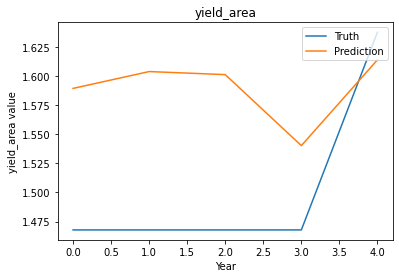

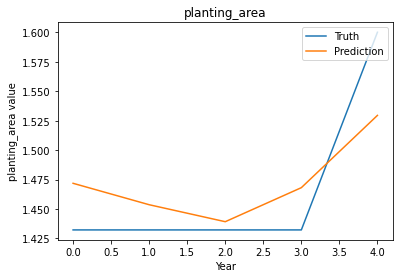

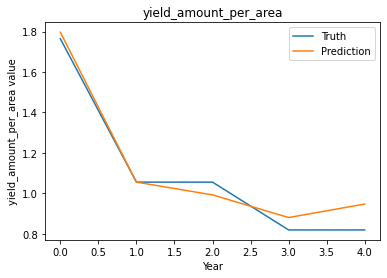

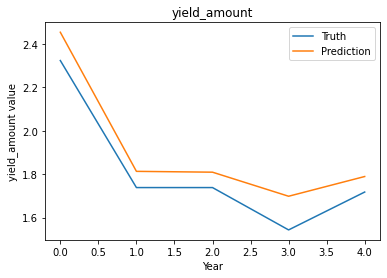

In [ ]:
for coli in range(predRes.shape[1]):
  plt.plot(Y_test_df.to_numpy()[:,coli])
  plt.plot(predRes[:,coli])  
  plt.title(Y_test_df.columns[coli])
  plt.ylabel(Y_test_df.columns[coli]+' value')
  plt.xlabel('Year')
  plt.legend(['Truth', 'Prediction'], loc='upper right')
  plt.show()

# 模型解釋

In [ ]:
modelInputValData

{'Precp': array([[[ 0.27737514],
         [ 0.33081747],
         [ 0.35308854],
         ...,
         [-0.185314  ],
         [ 0.4916963 ],
         [ 0.7330421 ]],
 
        [[-0.52140192],
         [ 1.08359966],
         [ 0.72061514],
         ...,
         [-0.37189013],
         [-0.38654931],
         [-0.37220606]],
 
        [[ 1.56822583],
         [ 3.88855239],
         [ 0.55244388],
         ...,
         [ 0.0991718 ],
         [ 2.83047524],
         [ 2.03631389]],
 
        ...,
 
        [[-0.28379102],
         [-0.01440748],
         [-0.97780326],
         ...,
         [ 1.78246506],
         [-0.46859705],
         [-0.35236827]],
 
        [[-0.51550377],
         [-0.7182828 ],
         [-0.75283243],
         ...,
         [-0.76455585],
         [-0.75325244],
         [-0.43242792]],
 
        [[-0.70255916],
         [-0.35196077],
         [-0.59579833],
         ...,
         [-0.79194318],
         [ 0.11201623],
         [-0.43915859]]]), 'Precp1Day

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
import tensorflow.keras.backend as K
import shap
import os, copy

model = os.path.join(os.sep,'content','model_for_yieldprediction-simpleLSTM-epoch00011-val_loss0.0441.h5')
model = tf.keras.models.load_model(model)
explainer = shap.DeepExplainer(model, modelInputTrainData)
shap_values = explainer.shap_values(modelInputValData)


if False:
  print("SHAP version is:", shap.__version__)
  print("Tensorflow version is:", tf.__version__)


  # select a set of background examples to take an expectation over
  background = copy.deepcopy(modelInputValData)

  explainer = shap.DeepExplainer(
      (model.layers[0].input, model.layers[-1].output), background
  )
  shap_values = explainer.shap_values(modelInputValData) # <-- HERE !

  # print the JS visualization code to the notebook
  shap.initjs()
  shap.force_plot(
      explainer.expected_value[0], shap_values[0][0], feature_names=X_train.columns
  )

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


AttributeError: ignored

# Backup

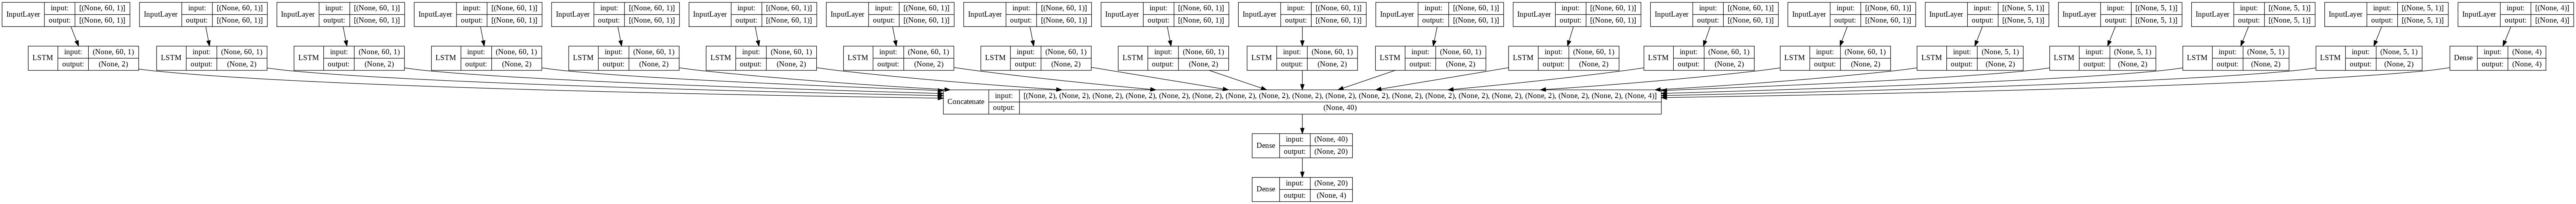

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

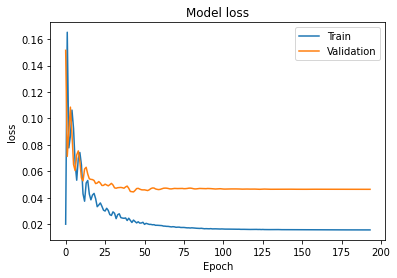

key loss; Min 0.01561516523361206; Max 0.16522158682346344


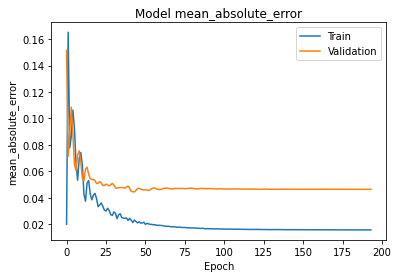

key mean_absolute_error; Min 0.01561516523361206; Max 0.16522158682346344


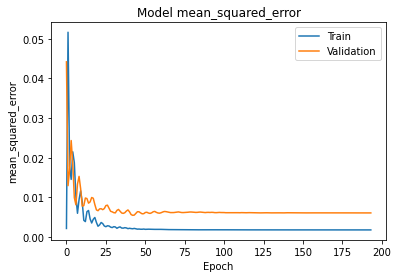

key mean_squared_error; Min 0.0017584412125870585; Max 0.05167023092508316


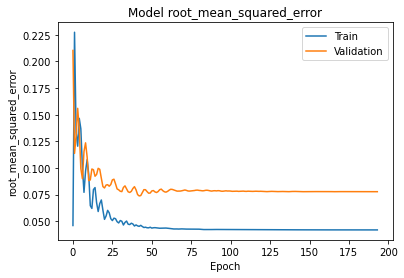

key root_mean_squared_error; Min 0.04193377122282982; Max 0.2273108810186386
'val_lr'


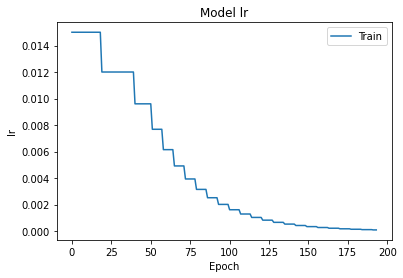

key lr; Min 8.854438783600926e-05; Max 0.014999999664723873


In [ ]:
for key in modelhistory.history:
  if key.find('val')!=-1: continue
  plt.plot(modelhistory.history[key])
  try:
    plt.plot(modelhistory.history['val_'+key])
  except Exception as e:
    print(str(e))
  plt.title('Model '+key)
  plt.ylabel(key)
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()
  print("key {}; Min {}; Max {}".format(key, min(modelhistory.history[key]), max(modelhistory.history[key])))

In [ ]:
finalmodelname = "/content/ckpt/model_for_yieldprediction-simpleLSTM-epoch00011-val_loss0.0441.h5"
finalmodelname_parent = finalmodelname.replace("ckpt/","")
!cp $finalmodelname $finalmodelname_parent
!rm /content/ckpt/ -R
!mkdir /content/ckpt/

In [ ]:
!tensorflowjs_converter --input_format keras /content/model_for_yieldprediction-simpleLSTM-epoch00011-val_loss0.0441.h5 /content/tfjs/

2021-07-27 19:03:17.617597: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [ ]:
def get_yield_data_df(formdata):
  s = requests.Session()
  yield_data_raw = s.post("https://agr.afa.gov.tw/afa/pgcroptown.jsp", data = formdata) #, cookies=cookies
  yield_data_raw = etree.HTML(yield_data_raw.text)
  yieldcity = yield_data_raw.xpath("//table[@class='TDFont']")[0] #
  yieldcity = yieldcity.xpath(".//td[contains(., '縣市')]/text()")[0]
  yieldcity = yieldcity.replace("縣市：","")
  yield_data_raw = yield_data_raw.xpath("//table[@class='TDFont']")[1]
  yield_data_raw = etree.tostring(yield_data_raw)
  yield_data_raw = pd.read_html(yield_data_raw)[0]
  targetrows = len(yield_data_raw.index)
  targetrows = [n for n in range(targetrows) if n!=1]
  yield_data_raw = yield_data_raw.iloc[targetrows,:]
  yield_data_raw.columns = yield_data_raw.iloc[0]
  yield_data_raw = yield_data_raw[1:]
  yield_data_raw = yield_data_raw.assign(city=yieldcity,yield_year=int(formdata['accountingyear'])+1911)
  yield_data_raw = yield_data_raw[(~yield_data_raw['縣市鄉鎮名稱'].str.contains('查無資料')) & (~yield_data_raw['縣市鄉鎮名稱'].str.contains('合 計'))]
  try:
    yield_data_raw['district'] = yield_data_raw.apply(lambda x: x['縣市鄉鎮名稱'].replace( x['city'],"" ), axis=1)
  except Exception as e:
    print("error at {} for {}".format(formdata,e))
    display(yield_data_raw)
    yield_data_raw['district'] = ""
  yield_data_raw = city_replace_in_df(yield_data_raw, ['縣市鄉鎮名稱','city','district'])
  yield_data_raw['citydistrict'] = yield_data_raw['縣市鄉鎮名稱']
  return yield_data_raw

def get_yield_datas_df():
  cities = list(range(7,8)) if False else list(range(1,19))+[20,63,65,66]
  cities = [str(city).zfill(4) for city in cities]
  years = range(108,109) if False else range(97,109)
  years = [n for n in years]
  formdatas = [{
      'accountingyear': year,
      'item': '03',
      'crop': '337',
      'city': city,
  } for year in years for city in cities]
  yield_data_raw = [dask.delayed(get_yield_data_df)(formdata) for formdata in formdatas]
  yield_data_raw = dask.compute(*yield_data_raw, num_workers=2, scheduler=defaultscheduler) #defaultnum_workers
  return yield_data_raw

coffee_yield_df = get_yield_datas_df()
coffee_yield_df = [ndf for ndf in coffee_yield_df if len(ndf.index)>0]
coffee_yield_df = pd.concat(coffee_yield_df).reset_index(drop=True)
backup_coffee_yield_df = copy.deepcopy(coffee_yield_df)
display(coffee_yield_df)

In [ ]:
coffee_yield_df = copy.deepcopy(backup_coffee_yield_df)
coffee_yield_df['收穫面積(公頃)'] = coffee_yield_df['收穫面積'].astype(float)
coffee_yield_df['種植面積(公頃)'] = coffee_yield_df['種植面積'].astype(float)
coffee_yield_df['每公頃收穫量(公斤)'] = coffee_yield_df['每公頃收量'].astype(float)
coffee_yield_df['收量(公斤)'] = coffee_yield_df['收量'].astype(float)
display(coffee_yield_df[coffee_yield_df['縣市鄉鎮名稱']=='新竹縣五峰鄉'])
coffee_yield_df.to_csv("coffee_yield_df.csv")

0    縣市鄉鎮名稱  種植面積  收穫面積 每公頃收量  ... 收穫面積(公頃) 種植面積(公頃)  每公頃收穫量(公斤)  收量(公斤)
109  新竹縣五峰鄉  2.50  2.50   350  ...      2.5      2.5       350.0   875.0
205  新竹縣五峰鄉  2.50  2.50   350  ...      2.5      2.5       350.0   875.0
413  新竹縣五峰鄉  2.50  2.50   400  ...      2.5      2.5       400.0  1000.0
530  新竹縣五峰鄉  2.50  2.50   400  ...      2.5      2.5       400.0  1000.0
677  新竹縣五峰鄉  2.50  2.50   400  ...      2.5      2.5       400.0  1000.0
778  新竹縣五峰鄉  2.50  2.50   400  ...      2.5      2.5       400.0  1000.0
925  新竹縣五峰鄉  2.50  2.50   600  ...      2.5      2.5       600.0  1500.0

[7 rows x 13 columns]

In [ ]:
yield_data_df.loc[failed_match_stations,['city','district','yield_year']]

In [ ]:
station_monthly_data_col_definition = dict(zip(
    list(station_monthly_data[0]),
    "觀測時間(day)	測站氣壓(hPa)	海平面氣壓(hPa)	測站最高氣壓(hPa)	測站最高氣壓時間(LST)	測站最低氣壓(hPa)	測站最低氣壓時間(LST)	氣溫(℃)	最高氣溫(℃)	最高氣溫時間(LST)	最低氣溫(℃)	最低氣溫時間(LST)	露點溫度(℃)	相對溼度(%)	最小相對溼度(%)	最小相對溼度時間(LST)	風速(m/s)	風向(360degree)	最大陣風(m/s)	最大陣風風向(360degree)	最大陣風風速時間(LST)	降水量(mm)	降水時數(hour)	最大十分鐘降水量(mm)	最大十分鐘降水量起始時間(LST)	最大六十分鐘降水量(mm)	最大六十分鐘降水量起始時間(LST)	日照時數(hour)	日照率(%)	全天空日射量(MJ/㎡)	能見度(km)	A型蒸發量(mm)	日最高紫外線指數	日最高紫外線指數時間(LST)	總雲量(0~10)".split("	")
))
station_monthly_data_all_directly_matched = pd.concat(station_monthly_data).reset_index(drop=True)
#display(station_monthly_data_col_definition)
display(station_monthly_data_all_directly_matched.rename(columns=station_monthly_data_col_definition).head(n=5))
station_monthly_data_all.to_csv('station_monthly_data_all_directly_matched.csv')

In [ ]:
model_input_x = list()
model_input_y = list()
for succeed_match_station in succeed_match_stations:
  t = pd.merge(
      left=pd.DataFrame(stationinfos).loc[[succeed_match_station],:],
      right=station_monthly_data_all,
      how='inner'
  )
  t = t.loc[:,['StnPres','Temperature','WS','WD','Precp','SunShine']].values.tolist()
  model_input_x.append(t)
  model_input_y.append(yield_data_df.loc[succeed_match_station,'每公頃收穫量(公斤)'])
#.values.tolist()

In [ ]:
yield_data_df.index

In [ ]:
for i,x in enumerate(model_input_x):
  print("I is "+str(i))
  print(model_input_y[i])
  #display(yield_data_df.iloc[model_input_y[i],:])
  print(x)


In [ ]:
display(yield_data_df)

Empty DataFrame
Columns: []
Index: []

### 找出有產量資料中有完整資料（所有年度都有）的鄉鎮市區

In [ ]:
completed_cases_stations_df = coffee_yield_df.groupby(['city','district'])['收量(公斤)'].agg(['mean', 'count']).sort_values(by=['count','mean'],ascending=False).reset_index(drop=False)
completed_cases_stations_df = completed_cases_stations_df[completed_cases_stations_df['count']==max(completed_cases_stations_df['count'])]
#completed_cases_stations = completed_cases_stations_df['鄉鎮'].to_list()
display(coffee_yield_df.head(n=5)) #.head(n=50)
display(completed_cases_stations_df)
completed_cases_stations_df = completed_cases_stations_df[['city','district']]
#display(completed_cases_stations_df.head(n=5)) #.head(n=50)

0    縣市鄉鎮名稱   種植面積   收穫面積 每公頃收量  ... 種植面積(公頃) 每公頃收穫量(公斤)   收量(公斤) district
68   桃園市大溪區   0.05   0.00     0  ...     0.05        0.0      0.0      大溪區
79  屏東縣三地門鄉  63.85  63.85   900  ...    63.85      900.0  57465.0     三地門鄉
80   屏東縣內埔鄉   1.10   1.10   900  ...     1.10      900.0    990.0      內埔鄉
81   屏東縣竹田鄉   0.42   0.42   800  ...     0.42      800.0    336.0      竹田鄉
82   屏東縣來義鄉   6.50   6.50   900  ...     6.50      900.0   5850.0      來義鄉

[5 rows x 13 columns]

city district          mean  count
0   南投縣      國姓鄉  64275.333333      3
1   南投縣      仁愛鄉  17925.333333      3
2   南投縣      魚池鄉  12704.000000      3
3   南投縣      鹿谷鄉  10961.000000      3
4   南投縣      水里鄉  10660.000000      3
5   台中市      和平區   7790.666667      3
6   台中市      東勢區   6666.666667      3
7   台中市      新社區   5654.000000      3
8   南投縣      信義鄉   4600.666667      3
9   南投縣      埔里鎮   4014.000000      3
10  宜蘭縣      大同鄉   3384.333333      3
11  台中市      太平區   3318.666667      3
12  南投縣      南投巿   2401.666667      3
13  苗栗縣      卓蘭鎮   2102.333333      3
14  宜蘭縣      南澳鄉   2097.000000      3
15  宜蘭縣      蘇澳鎮   1164.333333      3
16  苗栗縣      三灣鄉   1150.000000      3
17  南投縣      竹山鎮   1005.333333      3
18  台中市      霧峰區    938.666667      3
19  南投縣      名間鄉    900.333333      3
20  台中市      潭子區    712.000000      3
21  苗栗縣      獅潭鄉    664.666667      3
22  南投縣      中寮鄉    501.666667      3
23  宜蘭縣      三星鄉    416.666667      3
24  宜蘭縣      冬山鄉    282.000000      3
25  宜蘭縣      礁溪鄉    278.333333      3
26  宜蘭縣      員山鄉     41.666667      3
27  南投縣      集集鎮     28.333333      3
28  宜蘭縣      宜蘭巿     23.000000      3

## 從產量資料找出相對應的氣象測站
要將產量資料和測站觀測資料配對串連

In [ ]:
#一年觀測資料 一年觀測資料-局屬地面測站觀測資料 https://opendata.cwb.gov.tw/dataset/climate/C-B0024-002
#每月氣象-過去9年局屬地面測站每月氣象資料 https://opendata.cwb.gov.tw/dataset/climate/C-B0026-002
#每日雨量-過去9年局屬地面測站每日雨量資料 https://opendata.cwb.gov.tw/dataset/climate/C-B0025-002
#抓資料介面 https://opendata.cwb.gov.tw/dist/opendata-swagger.html?urls.primaryName=openAPI#/
#https://e-service.cwb.gov.tw/HistoryDataQuery/
#view-source:https://e-service.cwb.gov.tw/HistoryDataQuery/QueryDataController.do?command=viewMain

stationinfos = list()
succeed_match_stations = list()
succeed_match_stations_df = list()
failed_match_stations = list()
stationsinfos_mismatched = list()
mismatched_stations_df = list()
duplicated_match_stations = list()
paddedmonths = [str(m).rjust(2, '0') for m in range(1,13)]
"""
stationinfos a list of dict where its content is as follows

    {'stationid': 'C0A920',
      'stationname': '富貴角',
      'city': '新北市',
      'district': '石門區',
      'month': '07',
      'year': '2008',
      'yield_year': 2008},

succeed_match_stations: a list of the row number of yield data where there is a matched station

succeed_match_stations_df

failed_match_stations: a list of the row number of yield data where there is a mismatched station

duplicated_match_stations: a list of the row number of yield data where there are multiple matched stations(multiple stations in a district)
"""

for yield_data_df_n in range(len(yield_data_df.index)):
  temp_basis_df = yield_data_df.loc[[yield_data_df_n],['city','district','yield_year']].reset_index(drop=True)
  print("yield_data_df_n={} and temp_basis_df is:".format(yield_data_df_n))
  #display(temp_basis_df)
  temp_basis_series = yield_data_df.loc[yield_data_df_n,['city','district','yield_year']]
  targetfetchyears = list(range(temp_basis_series['yield_year']-5, temp_basis_series['yield_year']+1))
  temp_basis_df_2 = temp_basis_df.drop(columns=['yield_year']).reset_index(drop=True)
  #print("temp_basis_df_2 is:")
  #display(temp_basis_df_2)
  needed_station_df = pd.merge(left=weather_station_attr_df_preferred,right=temp_basis_df_2,how='inner')
  if len(needed_station_df.index)>0:
    """
    needed_station_df found 讀取天氣觀測資料
    """
    succeed_match_stations.append(yield_data_df_n)
    print("needed_station_df found")
    if len(needed_station_df.index)>1: duplicated_match_stations.append(yield_data_df_n)
    needed_station_df_simplified = needed_station_df.loc[:,['stationid','stationname','city','district']]
    needed_station_df_simplified = pd.concat([needed_station_df_simplified.assign(month=m) for m in paddedmonths]  ).reset_index(drop=True)
    needed_station_df_simplified = pd.concat([needed_station_df_simplified.assign(year=str(y)) for y in targetfetchyears]  ).reset_index(drop=True)
    needed_station_df_simplified['matchingtype'] = 'samedistrict'
    stationinfos.extend(
        [{**nd,**temp_basis_df.to_dict('records')[0]} for nd in needed_station_df_simplified.to_dict('records')]
        )
  else:
    """
    needed_station_df not found, find nearest station instead
    """
    print("needed_station_df not found")
    failed_match_stations.append(yield_data_df_n)
    axis = pd.merge(left=district_center_df,right=temp_basis_df_2,how='inner')
    try:
      axis = axis.loc[:,['中心點經度','中心點緯度']].to_dict('records')[0]
    except Exception as wrongaxis:
      display(temp_basis_df_2)
      display(axis)
      print(str(wrongaxis))
      break
    #計算離產量資料鄉鎮市區最近的氣象站並且串接
    axis_np = list(axis.values())
    nearest_station_axis = weather_station_attr_df_preferred
    nearest_station_axis['combined_axis'] = nearest_station_axis.loc[:,['經度','緯度']].values.tolist()
    nearest_station_axis['distance'] = nearest_station_axis['combined_axis'].apply(distance.euclidean, v=axis_np)
    nearest_station_axis = nearest_station_axis.sort_values(by=['distance'], ascending=True).reset_index(drop=True).loc[[0],:].reset_index(drop=True)
    needed_station_df_simplified = temp_basis_df.rename(columns={'city':'yieldcity','district':'yielddistrict'}).reset_index(drop=True)
    needed_station_df_simplified = pd.concat([nearest_station_axis, needed_station_df_simplified], axis=1).reset_index(drop=True)
    mismatched_stations_df.append(needed_station_df_simplified)
    #display(nearest_station_axis)
    #display(needed_station_df_simplified)
    #break
    needed_station_df_simplified = pd.concat([needed_station_df_simplified.assign(month=m) for m in paddedmonths]  ).reset_index(drop=True)
    needed_station_df_simplified = pd.concat([needed_station_df_simplified.assign(year=str(y)) for y in targetfetchyears]  ).reset_index(drop=True)
    needed_station_df_simplified['matchingtype'] = 'nearest'
    needed_station_df_simplified = needed_station_df_simplified.loc[:,['stationid','stationname','city','district','month','year','yield_year']].to_dict('records')
    stationsinfos_mismatched.extend(needed_station_df_simplified)
  #if yield_data_df_n>11:
  #  break
  if False:
    urlencoded_name = urllib.parse.quote(temp_basis_df_for_mergeweather['stationname'][0], safe='~@#$&()*!+=:;,.?/\'', encoding='UTF-8').replace("%","%25")
    sinfo_weather_data_raw = "https://e-service.cwb.gov.tw/HistoryDataQuery/MonthDataController.do?command=viewMain&station={}&datepicker=-&stname={}".format(temp_basis_df_for_mergeweather['stationid'][0], urlencoded_name)
    station_info_message_ori = temp_basis_df_for_mergeweather.loc[:,['stationid','stationname','yield_year']].to_dict('records')[0]
    try:
      station_info_message = map(str,list(station_info_message_ori.values()))
      t = "processing "+" ".join(station_info_message+[sinfo_weather_data_raw])
    except Exception as joinerror:
      print(str(joinerror))
      display(temp_basis_df_for_mergeweather)
      display(station_info_message_ori)
      break

=1253 and temp_basis_df is:
needed_station_df not found
yield_data_df_n=1254 and temp_basis_df is:
needed_station_df found
yield_data_df_n=1255 and temp_basis_df is:
needed_station_df not found
yield_data_df_n=1256 and temp_basis_df is:
needed_station_df not found
yield_data_df_n=1257 and temp_basis_df is:
needed_station_df found
yield_data_df_n=1258 and temp_basis_df is:
needed_station_df found
yield_data_df_n=1259 and temp_basis_df is:
needed_station_df not found
yield_data_df_n=1260 and temp_basis_df is:
needed_station_df found
yield_data_df_n=1261 and temp_basis_df is:
needed_station_df found
yield_data_df_n=1262 and temp_basis_df is:
needed_station_df not found
yield_data_df_n=1263 and temp_basis_df is:
needed_station_df not found
yield_data_df_n=1264 and temp_basis_df is:
needed_station_df not found
yield_data_df_n=1265 and temp_basis_df is:
needed_station_df not found
yield_data_df_n=1266 and temp_basis_df is:
needed_station_df not found
yield_data_df_n=1267 and temp_basis_df is

In [ ]:
start_time = time.time()
overall_stationinfos = stationinfos+stationsinfos_mismatched
unique_stationinfos = pd.DataFrame(overall_stationinfos).drop(columns=['yield_year']).drop_duplicates().reset_index(drop=True).to_dict('records')
station_monthly_data = [dask.delayed(get_station_monthly_data_retrieve)(stationinfo) for stationinfo in unique_stationinfos[0:101]]
needscheduler = "threads" if True else "processes"
"""
for sinfo in unique_stationinfos:
    station_info_message = list(sinfo.values())
    sinfo['urlencoded_name'] = urllib.parse.quote(sinfo['stationname'], safe='~@#$&()*!+=:;,.?/\'', encoding='UTF-8').replace("%","%25")
    sinfo_weather_data_raw = "https://e-service.cwb.gov.tw/HistoryDataQuery/MonthDataController.do?command=viewMain&station={}&datepicker={}-{}&stname={}".format(sinfo['stationid'], sinfo['year'], sinfo['month'], sinfo['urlencoded_name'])
    try:
        t = "processing "+" ".join(station_info_message+[sinfo_weather_data_raw])
    except Exception as e:
        print(str(e))
        display(sinfo)
        break
"""
if True:
    with dask.config.set(num_workers=30, scheduler=needscheduler):  #204
        with ProgressBar():
            station_monthly_data_retrieved = dask.compute(*station_monthly_data)
    with dask.config.set(num_workers=600, scheduler=needscheduler):
        with ProgressBar():
            station_monthly_data = [dask.delayed(get_station_monthly_data_parse)(smd) for smd in station_monthly_data_retrieved]
            station_monthly_data = dask.compute(*station_monthly_data)
needtime = time.time() - start_time
print("--- %s seconds ---" % (needtime))
#110.41256833076477 12 workers processes
#110.30883741378784 12 workers threads
#35.71750545501709 60 workers processes
#26.521867990493774 60 workers threads
#300 jobs
#269.1925961971283 60 workers threads 600 workers threads
#104.53193426132202 80 workers threads 600 workers threads
#104.78928446769714 84 workers threads 600 workers threads
#103.09000277519226 96 workers threads 600 workers threads
#84.36256146430969 108 workers threads 600 workers threads
#83.18865132331848 120 workers threads 600 workers threads
#81.80956053733826 132 workers threads 600 workers threads
#65.56309628486633 156 workers threads 600 workers threads
#65.40118169784546 180 workers threads 600 workers threads

ery/MonthDataController.do?command=viewMain&station=C0A920&datepicker=2006-09&stname=%25E5%25AF%258C%25E8%25B2%25B4%25E8%25A7%2592
processing C0A920 富貴角 新北市 石門區 08 2007 https://e-service.cwb.gov.tw/HistoryDataQuery/MonthDataController.do?command=viewMain&station=C0A920&datepicker=2007-08&stname=%25E5%25AF%258C%25E8%25B2%25B4%25E8%25A7%2592
processing C0A920 富貴角 新北市 石門區 01 2006 https://e-service.cwb.gov.tw/HistoryDataQuery/MonthDataController.do?command=viewMain&station=C0A920&datepicker=2006-01&stname=%25E5%25AF%258C%25E8%25B2%25B4%25E8%25A7%2592
processing C0A920 富貴角 新北市 石門區 08 2008 https://e-service.cwb.gov.tw/HistoryDataQuery/MonthDataController.do?command=viewMain&station=C0A920&datepicker=2008-08&stname=%25E5%25AF%258C%25E8%25B2%25B4%25E8%25A7%2592
processing C1I250 鯉潭 南投縣 埔里鎮 06 2003 https://e-service.cwb.gov.tw/HistoryDataQuery/MonthDataController.do?command=viewMain&station=C1I250&datepicker=2003-06&stname=%25E9%25AF%2589%25E6%25BD%25AD
processing C1I260 北坑 南投縣 埔里鎮 09 2003 http